# **Phase-2 Image Caption Generator:📸🎞**

In [ ]:
import os
import numpy as np
import pickle                 #for storing numpy features
from tqdm.notebook import tqdm  # for visulazing how much data is processsed
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications.vgg16 import  VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add


In [ ]:
# defining some paths
BASE_DIR = '/content/drive/MyDrive/Intern Project/Phase 2 - Intern project'
WORKING_DIR = '/content/drive/MyDrive/Intern Project/Phase 2 - Intern project/'

# **EXTRACT IMAGE FEATURES**

In [ ]:
#load vgg16 model
vgg_model = VGG16()
# restructuring the model since we don't need the last softmax(prediction layer)
vgg_model = Model (inputs = vgg_model.inputs, outputs = vgg_model.layers[-2].output)
#summarize
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
# extract features from image
features = {}              # dict for storing the features of an image
directory = os.path.join(BASE_DIR, 'Images')
for img_name in tqdm(os.listdir(directory)):

    # load image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size = (224,224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    # preprocess the image for vgg
    image = preprocess_input(image)
    # extracting features
    feature =  vgg_model.predict(image , verbose = 0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8101 [00:00<?, ?it/s]

In [ ]:
#storing features in pickle
# this will save us re-running the above cell every time we start a new session
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

# **Load The Caption Data**

In [ ]:
# load features from pickle
with open(os.path.join('/content/drive/MyDrive/Intern Project/Phase 2 - Intern project/', 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
# creating mapping from image to caption
mapping = {}
# preprocess the line
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # removing extension from image_ids
    image_id = image_id.split('.')[0]
    #convert caption list to string
    caption = " ".join(caption)
    # since image can have multiple captions, we will store them in a list
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)


  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping)

8091

In [ ]:
def clean(mapping):
    for keys, captions in mapping.items():
        for i in range (len(captions)):
            # taking one caption at a time
            caption = captions[i]
            #preprocessing step
            #converting to lower case
            caption = caption.lower()
            #delete digits, special chars, etc.
            caption = caption.replace('[^A_Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

In [ ]:
#before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
#after preprocessing
clean(mapping)
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

40455

In [ ]:
# tokenizing the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size =len(tokenizer.word_index) + 1

In [ ]:
vocab_size

8485

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

# **Train Test Split**

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split : ]

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

# **Model Creation**

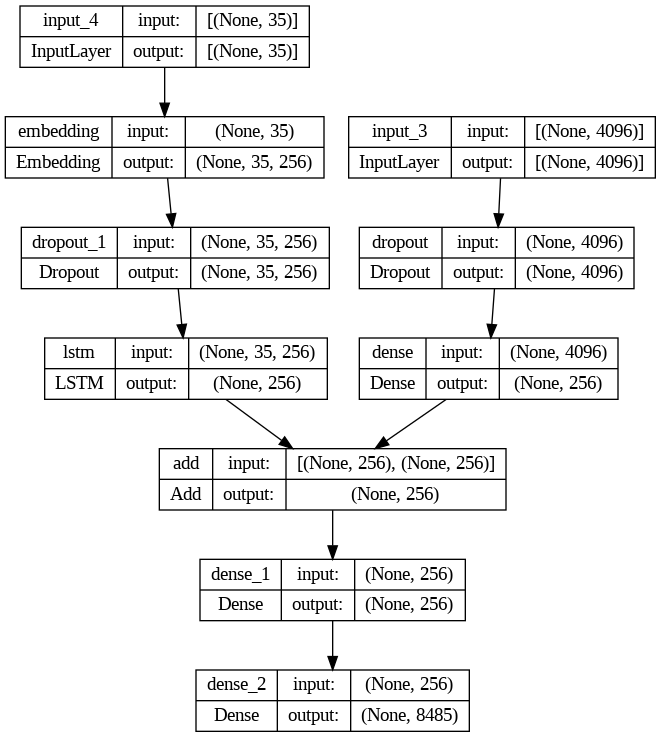

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

# **Saving model and tokenizer**

In [ ]:
# save the model
model.save('/content/drive/MyDrive/Intern Project/Phase 2 - Intern project/model.h5')

In [ ]:
import pickle
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# **Loading the model and tokenizer from the file**

In [ ]:
#load model from file
# the model below is trained for around 50 epochs, this is the best I can do given the limited computation and time I have.
import tensorflow as tf
model = tf.keras.models.load_model('/content/drive/MyDrive/Intern Project/image caption/model.h5')

In [ ]:
# loading
with open('/content/drive/MyDrive/Intern Project/image caption/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# **Generate Captions for the Image**

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test[:30]):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, 35)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/30 [00:00<?, ?it/s]

BLEU-1: 0.491122
BLEU-2: 0.282401


# **Visualize the Results**

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black and white dog catches toy in midair endseq
startseq dog and tennis ball endseq
startseq "a dog is jumping to catch object thrown at it endseq
startseq dog leaps while chasing tennis ball through grassy field endseq
startseq multicolor dog jumping to catch tennis ball in grassy field endseq
--------------------Predicted--------------------
startseq black and white dog is jumping in the air to catch ball in field endseq


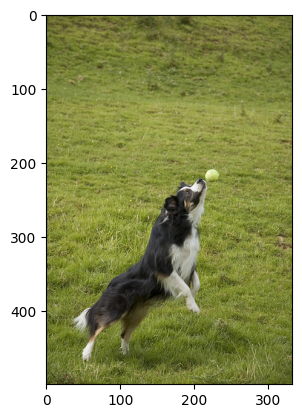

In [ ]:
generate_caption("1072153132_53d2bb1b60.jpg")

---------------------Actual---------------------
startseq brown dog is running through neck-deep water carrying tennis ball endseq
startseq brown dog splashes in the water while carrying ball in its mouth endseq
startseq brown dog swims through water outdoors with tennis ball in its mouth endseq
startseq "a red dog holding ball splashes through vegetation filled water ." endseq
startseq "brown dog with tennis ball in mouth in water and bushes ." endseq
--------------------Predicted--------------------
startseq brown dog is carrying stick in its mouth while swimming endseq


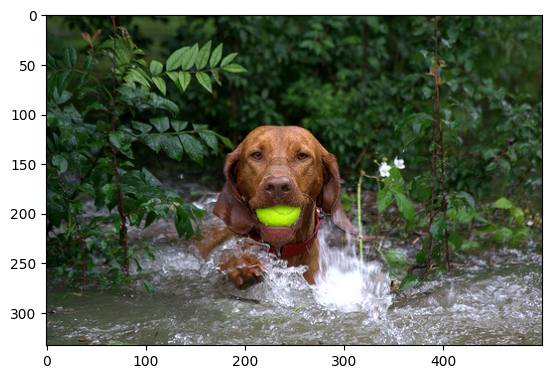

In [ ]:
generate_caption("1130369873_d80a1aa59c.jpg")

---------------------Actual---------------------
startseq boy playing in lake endseq
startseq child is splashing in the water endseq
startseq little boy is playing in the water with beautiful sunset and mountains in the background endseq
startseq small child in water with splash encircling him while the white clouds float over the mountains endseq
startseq young boy plays in the water with the mountains in the background endseq
--------------------Predicted--------------------
startseq woman stands on the edge of the water with her arms in the water endseq


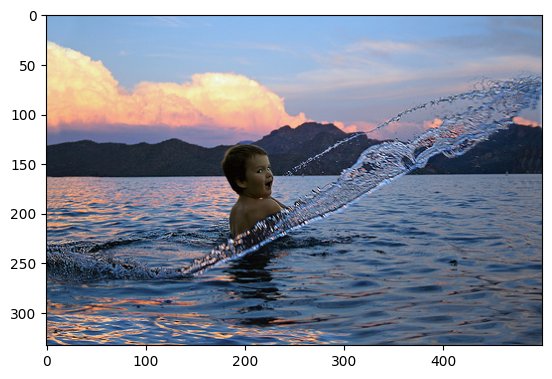

In [ ]:
generate_caption("1255504166_f2437febcb.jpg")

---------------------Actual---------------------
startseq boy in red and white shirt is on swing endseq
startseq child looking back on fast moving swing endseq
startseq litlle boy playing on swing endseq
startseq young boy in orange and white swings in playground at park endseq
startseq young boy plays on swing endseq
--------------------Predicted--------------------
startseq boy is swinging on swing endseq


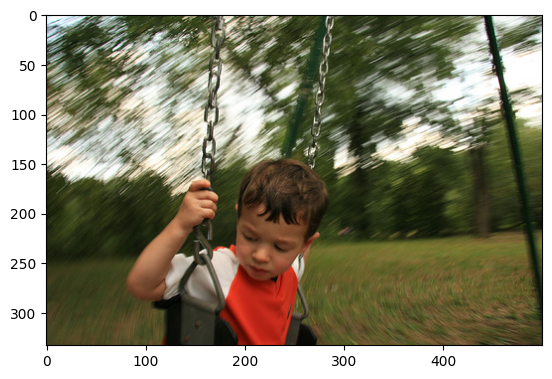

In [ ]:
generate_caption("1222322358_225067636e.jpg")

---------------------Actual---------------------
startseq black and tan dog in the snow endseq
startseq brown furry husky dog sticking out his tongue endseq
startseq dog wearing blue harness stands in the snow and pants endseq
startseq husky dog wearing green straps is turning its head away from the object in front of it endseq
startseq husky dog wearing the gear to pull sled endseq
--------------------Predicted--------------------
startseq husky dog carries white dog through snow endseq


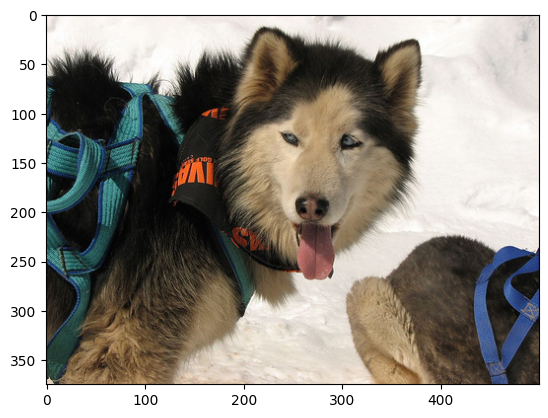

In [ ]:
generate_caption("1287064529_aa4e4f3c31.jpg")

---------------------Actual---------------------
startseq biker enjoys coffee endseq
startseq man in bright green shirt and sunglasses is riding bicycle through the streets whilst drinking latte endseq
startseq "a man in bright green shirt riding bicycle in paved courtyard carying drink ." endseq
startseq man rides on his bike with one hand and holds drink with the other endseq
startseq man riding bike wearing green shirt with drink in his hand endseq
--------------------Predicted--------------------
startseq man riding bike on street endseq


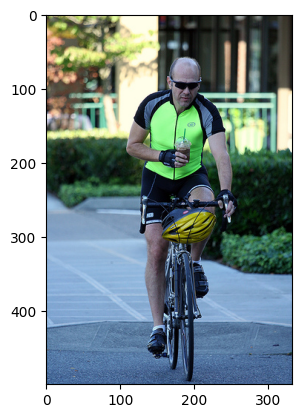

In [ ]:
generate_caption("1262583859_653f1469a9.jpg")

In [ ]:
#Code to predict caption of real images
image_path = "/content/drive/MyDrive/Intern Project/Phase 2 - Intern project/Images/105342180_4d4a40b47f.jpg" #path of your image
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, 35)

'startseq woman paddles boat down river endseq'